# Population Simulator

In [14]:
import random
from matplotlib import pyplot as plt
import uuid

In [216]:
class Individual(object):
    """This class represents an individual."""

    def __init__(self, gamete1, gamete2):
        """
        @param genes1: sequence of alleles on first "chromosome".
        Each allele is a symbol; typically an integer or a random string.
        @param genes2: sequence of alleles on second "chronosome". """
        self.chromosomes = list(zip(gamete1, gamete2))

    @staticmethod
    def create_random(num_genes=1, num_alleles=2):
        gene1, gene2 = [[random.randint(0, num_alleles - 1) for _ in range(num_genes)] for g in range(2)]
        # gene1, gene2 = [[uuid.uuid4() for _ in range(num_genes)] for g in range(2)]
        return Individual(gene1, gene2)

    def gamete(self):
        """Returns random gamete."""
        return [a[random.randint(0, 1)] for a in self.chromosomes]

    def __eq__(self, other):
        """Checks for genetic equality."""
        return self.chromosomes == other.chromosomes

    def __repr__(self):
        return str(self.chromosomes)


In [5]:
# chromosomes: [('A', 'a'), ('B', 'b')]
# Alleles: A, a, B, b
i = Individual(['A', 'B'], ['a', 'b'])
i.chromosomes


[('A', 'a'), ('B', 'b')]

In [212]:
from collections import defaultdict
class Population(object):
    """This class represents the snapshot of a population."""

    def __init__(self, individuals=None):
        self.individuals = individuals or []
        self.females, self.males = None, None
        self.gene_frequencies = []

    def __len__(self):
        return len(self.individuals)

    def __iter__(self):
        return iter(self.individuals)

    def is_monozygotic_for(self, gene):
        """ Returns TRUE if this gene is monozygotic; else FALSE """
        return self.chromosomes[gene][0] == self.chromosomes[gene][1]

    def add(self, individual):
        self.individuals.append(individual)

    def pick_individual(self):
        """Returns a random individual."""
        return random.choice(self.individuals)

    def random_mating(self):
        """Returns an individual produced via random mating."""
        g1 = self.pick_individual().gamete()
        g2 = self.pick_individual().gamete()
        return Individual(g1, g2)

    def random_hermaphrodite_mating(self):
        """Returns an individual generated via non-self mating,
        aka Banana Slug mating."""
        i1, i2 = random.sample(self.individuals, k=2)
        g1 = i1.gamete()
        g2 = i2.gamete()
        return Individual(g1, g2)

    def partition_genders_randomly(self, prob=0.5):
        """Partition the population in genders, randomly.
        Returns whether there is at least somebody of both genders."""
        self.males, self.females = [], []
        for x in self.individuals:
            if random.random() < prob:
                self.females.append(x)
            else:
                self.males.append(x)
        return len(self.females) > 0 and len(self.males) > 0

    def random_sexual_mating(self, prob=0.5):
        """This is a simple model, in which mating can happen only between
        individuals of opposite sex, and we are given the probability that an
        individual is of a given sex.
        We could do things in another way, but this is ok for now."""
        if self.females is None and self.males is None:
            feasible = self.partition_genders_randomly(prob=prob)
            if not feasible:
                return None
        f = random.choice(self.females)
        m = random.choice(self.males)
        return Individual(f.gamete(), m.gamete())

    def get_generation(self, method, pop_size=None, *args, **kwargs):
        """Gets a new generation according to the given method."""
        if pop_size == None:
            pop_size = len(self.individuals)

        new_pop = [method(self, *args, **kwargs) for _ in range(pop_size)]
        return Population(new_pop)


    def __repr__(self):
        """You can improve this..."""
        return "\n".join([str(i) for i in self.individuals])

    '''
    Calculates the frequency of each gene (combonation of alleles) in the current generation
    gene_frequencies is list of lists of [freq of AA, freq of Aa, freq of aa] for each generation
    '''
    def get_gene_frequencies(self):
        allele_freq = {'[1, 1]': 0, '[0, 1]': 0, '[0, 0]': 0}
        # allele_freq = defaultdict(lambda:0)
        total_alleles = 0

        for i in self.individuals:
            for chromosome in i.chromosomes:
                sorted_chromosome = str(sorted(chromosome))
                allele_freq[sorted_chromosome] += 1

                # if sorted_chromosome not in allele_freq:
                #     allele_freq[sorted_chromosome] = 1
                # else:
                #     allele_freq[sorted_chromosome] += 1

                total_alleles += 1
        
        prob_of_genes = {}
        for allele, freq in allele_freq.items():
            prob_of_genes[allele] = freq / total_alleles

        self.gene_frequencies.append(list(prob_of_genes.values()))
        return list(prob_of_genes.values())

    '''
    Caluclates prob of each allele at last generation of gene_frequencies
    gene_frequencies is list of lists of [freq of 11, freq of 01, freq of 00] for each generation
    :param gen: generation which to calculate allele probability, defaults to second from last
    '''
    def get_p_and_q(self, gene_frequencies, gen=-2):
        if len(gene_frequencies) < 2:
            return 0
        freq_of_genes = gene_frequencies[gen]
        N = len(self.individuals)

        # prob of A = (2(AA freq)N + (Aa freq)N) / 2N
        p_A = (2 * freq_of_genes[0] * N + freq_of_genes[1]*N) / (2*N)
        # prob of a = (2N * (aa freq) + N * (Aa freq)) / 2N
        p_a = (2 * freq_of_genes[2] * N + freq_of_genes[1]*N) / (2*N)

        return (p_A, p_a)
            
    '''
    Caluclate actual F based on the fraction of hetero vs homo alleles in gene_frequencies
    '''
    def calculate_true_F(self, gene_frequencies):
        if len(gene_frequencies) < 2:
            return 0

        freq_of_genes_last_gen = gene_frequencies[-1]
        # get frequency of alleles in 2nd to last generation
        p_0, p_1 = self.get_p_and_q(gene_frequencies, gen=-2)

        F = ((2*p_1*p_0) - freq_of_genes_last_gen[1]) / (2*p_1*p_0) if p_1*p_0 != 0 else 0
        return F

    def get_fraction_hetero(self):
        gene_frequencies = self.get_gene_frequencies()
        freq_hetero = gene_frequencies[1]
        freq_homo = gene_frequencies[0] + gene_frequencies[2]

        exp_homo = (freq_homo/2)**2
        exp_hetero = 1-exp_homo
        return exp_homo
    
    '''
    Caluclate actual F based on the fraction of hetero vs homo alleles in gene_frequencies
    '''
    def calculate_F_heterozygote(self):
        N = len(self.individuals)

        allele_counts = defaultdict(int)
        for i in self.individuals:
            for chromosome in i.chromosomes:
                sorted_chromosome = str(sorted(chromosome))
                allele_counts[sorted_chromosome] += 1

        obs_homo = 0
        for allele in allele_counts:
            if (len(set(allele)) == len(allele)):
                obs_homo += (allele_counts[allele] / 2*N)**2

        exp_het = 1-obs_homo
        return (obs_homo) * -1

    '''
    p = frequency of allele A
    q = frequency of allele a
    H_o = 2pq = normal heterozygot frequency
    H = observed heterozygot frequency
    F = (H_o - H) / H_o
    compute heterozygocity and homozygocity, compare to harvey weindberg
    '''
    def calculate_expected_F(self, gene_frequencies):
        # homozygote_prob = 0
        # for allele, prob in prob_of_genes:
        #     if allele[0] == allele[1]:
        #         homozygote_prob += prob

        # return homozygote_prob

        # aa_freq, Aa_freq, AA_freq = self.full_fraction_list[-1]
        # N = len(self.individuals)
        # p_1 = (2 * aa_freq * N + Aa_freq*N) / (2*N)
        # p_0 = (2 * AA_freq * N + Aa_freq*N) / (2*N)
        # Fst = sigma**2 / (p1 * p2)
        pass

    # f_t0 = 0
    def get_estimated_fst(self, f_ls):
        N = len(self.individuals)

        return 1/(2*N) + (1-(1/(2*N))) * f_ls[-1] if len(f_ls) >= 1 else 0

        # return 0.5 * N * (1-(0.5 * N)) * (f_ls[-1]) if len(f_ls) >= 1 else 0
        # return 1/(2*N) + f_ls[-1] * (1-1/2*N) if len(f_ls) >= 1 else 0

Now random mating

In [195]:
import numpy as np
def normalize(arr):
    x = np.array(arr)
    x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
    return list(x_norm)


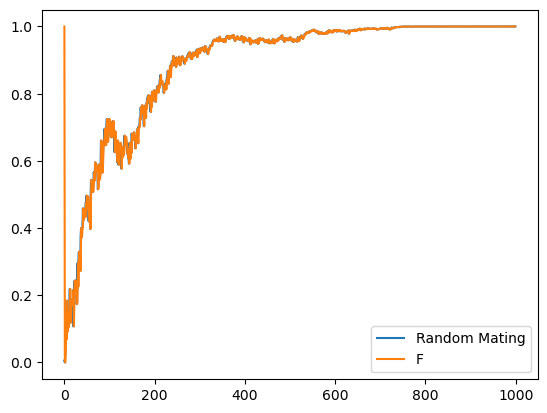

In [227]:
# Random Mating

pop_size = 100
init_pop = [Individual.create_random(num_genes=20) for _ in range(pop_size)]
pop = Population(init_pop)
random_mating_f_ls = []
random_mating_f_exp = []
gene_frequencies = []

# 1000 generations
for j in range(1000):
    # print(f'Generation {j}')
    # i = pop.random_mating()
    # pop.add(i)
    pop = pop.get_generation(Population.random_mating)
    # gene_frequencies.append(pop.get_gene_frequencies())

    # print(f'pop.gene_frequencies[-1]: {pop.gene_frequencies[-1]}')
    # F = pop.calculate_true_F(gene_frequencies)

    F = pop.calculate_F_heterozygote()
    f_exp = pop.get_estimated_fst(random_mating_f_ls)
    random_mating_f_exp.append(f_exp)
    
    # print(f'F: {F}')
    # print(pop.gene_frequencies)
    random_mating_f_ls.append(F)

    # print(pop)

random_mating_f_ls = normalize(random_mating_f_ls)
random_mating_f_exp = normalize(random_mating_f_exp)

plt.plot(random_mating_f_ls, label='Random Mating')
plt.plot(random_mating_f_exp, label='F')
plt.legend()
plt.show()

Random sexual mating w/ gender ratio 0.5

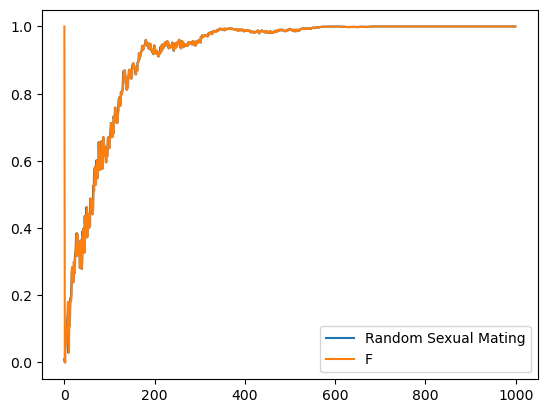

In [222]:
# Random sexual mating w/ 0.5

pop_size = 100
init_pop = [Individual.create_random(num_genes=20) for _ in range(pop_size)]
pop = Population(init_pop)
gene_frequencies = []
random_sexual_mating_f_ls = []
random_sexual_mating_true_f = []

for j in range(1000):
    # print(f'Generation {j}')

    pop = pop.get_generation(Population.random_sexual_mating)
    # gene_frequencies.append(pop.get_gene_frequencies())
    # print(f'fraction: {fraction}')
    # F = pop.calculate_true_F(gene_frequencies)
    F = pop.calculate_F_heterozygote()
    f_exp = pop.get_estimated_fst(random_sexual_mating_f_ls)
    random_sexual_mating_true_f.append(f_exp)
    
    # print(f'F: {F}')
    random_sexual_mating_f_ls.append(F)

    # print(pop)

random_sexual_mating_f_ls = normalize(random_sexual_mating_f_ls)
random_sexual_mating_true_f = normalize(random_sexual_mating_true_f)

plt.plot(random_sexual_mating_f_ls, label='Random Sexual Mating')
plt.plot(random_sexual_mating_true_f, label='F')
plt.legend()
plt.show()

Random sexual mating w/ gender ratio 0.9

1/2N + F_exp[gen]

Checking to see who has same gene from common ancestor
 - unique allele identifiers
F = population that has inbreeding / N

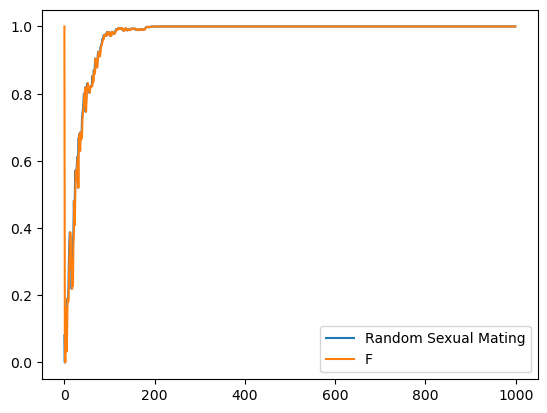

In [224]:
# Random sexual mating w/ 0.9

pop_size = 100
init_pop = [Individual.create_random(num_genes=20) for _ in range(pop_size)]
pop = Population(init_pop)
gene_frequencies = []
random_sexual_mating_09_f_ls = []
random_sexual_mating_true_f_09 = []

for j in range(1000):
    # print(f'Generation {j}')

    pop = pop.get_generation(Population.random_sexual_mating, None, 0.90)
    # gene_frequencies.append(pop.get_gene_frequencies())
    # print(f'fraction: {fraction}')
    # F = pop.calculate_true_F(gene_frequencies)
    F = pop.calculate_F_heterozygote()

    f_exp = pop.get_estimated_fst(random_sexual_mating_09_f_ls)
    random_sexual_mating_true_f_09.append(f_exp)

    # print(f'F: {F}')
    random_sexual_mating_09_f_ls.append(F)

    # print(pop)

random_sexual_mating_09_f_ls = normalize(random_sexual_mating_09_f_ls)
random_sexual_mating_true_f_09 = normalize(random_sexual_mating_true_f_09)

plt.plot(random_sexual_mating_09_f_ls, label='Random Sexual Mating')
plt.plot(random_sexual_mating_true_f_09, label='F')
plt.legend()
plt.show()

Random Hermaphrodite Mating

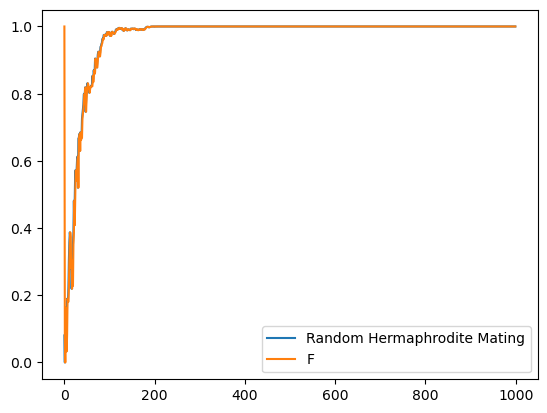

In [225]:
# random hermaphrodite mating
pop_size = 100
init_pop = [Individual.create_random(num_genes=20) for _ in range(pop_size)]
pop = Population(init_pop)
gene_frequencies = []
random_hermaphrodite_mating_f_ls = []
random_hermaphrodite_mating_true_f = []

for j in range(1000):
    # print(f'Generation {j}')

    pop = pop.get_generation(Population.random_hermaphrodite_mating)
    # gene_frequencies.append(pop.get_gene_frequencies())
    # print(f'fraction: {fraction}')
    # F = pop.calculate_true_F(gene_frequencies)
    F = pop.calculate_F_heterozygote()
    random_hermaphrodite_mating_f_ls.append(F)

    f_exp = pop.get_estimated_fst(random_hermaphrodite_mating_f_ls)
    random_hermaphrodite_mating_true_f.append(f_exp)

    # print(pop)

random_hermaphrodite_mating_f_ls = normalize(random_hermaphrodite_mating_f_ls)
random_hermaphrodite_mating_true_f = normalize(random_hermaphrodite_mating_true_f)

plt.plot(random_sexual_mating_09_f_ls, label='Random Hermaphrodite Mating')
plt.plot(random_sexual_mating_true_f_09, label='F')
plt.legend()
plt.show()

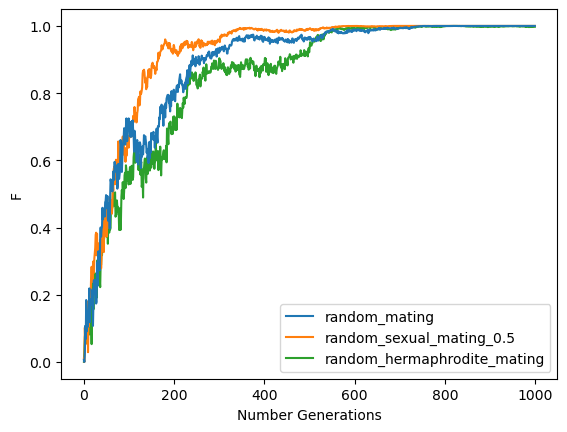

In [228]:
plt.plot(random_mating_f_ls, label='random_mating', zorder=10)
plt.plot(random_sexual_mating_f_ls, label='random_sexual_mating_0.5', zorder=5)
# plt.plot(random_sexual_mating_09_f_ls, label='random_sexual_mating_0.9')
plt.plot(random_hermaphrodite_mating_f_ls, label='random_hermaphrodite_mating')
plt.legend() 
plt.ylabel('F')
plt.xlabel('Number Generations')
plt.show()

Mutations: allow alleles to be created by random



IBD is same as heterozygosity


To get homozygosity:
    list_of_homozygotes = []
    for key, value in allele_counts.items():
    if len(value) != len(set(value)):
        list_of_homozygotes.append(key)

    list_of_all_individuals = list(allele_counts.keys())



Making new populations = replace current generation with old


compute f per gene

In [ ]:
# Let's simulate 100 generations.
pop_size = 100
init_pop = [Individual.create_random() for _ in range(pop_size)]
pop = Population(init_pop)

f_ls = []
for j in range(1000):
    i = Individual.create_random(num_genes=2)
    pop.add(i)
    pop.update_gene_frequencies()
    F = pop.calculate_true_F()
    # print(F)
    f_ls.append(F)

plt.plot(f_ls)
plt.show()